In [39]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import dataset
from tqdm.autonotebook import tqdm

cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if cuda else 'cpu')
tqdm.write('CUDA is not available!' if not cuda else 'CUDA is available!')
tqdm.write('')


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return torch.autograd.Variable(x)


image_transform = transforms.Compose([transforms.ToTensor()])


def get_data_loader(dataset_location, bs):
    trainvalid = torchvision.datasets.SVHN(dataset_location, split='train', download=False, transform=image_transform)

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(trainvalid, [trainset_size, len(trainvalid) - trainset_size])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2,
                                              drop_last=True)

    validloader = torch.utils.data.DataLoader(validset, batch_size=bs, drop_last=True)

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(dataset_location, split='test', download=False, transform=image_transform),
        batch_size=bs, drop_last=True)

    return trainloader, validloader, testloader


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear = nn.Linear(100, 512)

        self.convs = nn.Sequential(
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(512, 128, kernel_size=5, stride=2),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=6, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.convs(x.view(-1, 512, 1, 1))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(True),
            nn.Conv2d(128, 256, kernel_size=2),
            nn.LeakyReLU(True)
        )

        self.linear = nn.Linear(256, 1)

    def forward(self, x):
        x = self.convs(x)
        x = self.linear(x.view(-1, 256))
        return x


class WGANGPLoss(nn.Module):
    def __init__(self, lmb=10):
        super(WGANGPLoss, self).__init__()
        self.lmb = lmb

    def forward(self, disc, real, fake, bs):
        noise = torch.rand(bs, 1).expand(bs, 3 * 32 * 32).to(device)
        noise = noise.view(bs, 3, 32, 32)
        interpolates = noise * real + ((1.0 - noise) * fake)
        interpolates = Variable(interpolates, requires_grad=True).to(device)
        disc_interpolates = disc(interpolates)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device), create_graph=True,
                                        retain_graph=True, only_inputs=True)[0]
        gradient_penalty = self.lmb * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return real.mean() - fake.mean() - gradient_penalty


def train_func(epoch, gen, disc, crit, gen_optim, disc_optim, loader, bs):
    gen.train()
    disc.train()

    run_loss_gen = 0.
    run_loss_disc = 0.

    num_images_gen = 1
    num_images_disc = 0

    monitor = tqdm(loader, desc='train')
    iterations = 0
    for real_images, _ in monitor:
        real_images = real_images.to(device)

        iterations += 1

        disc(real_images)

        z_latent = torch.randn(bs, 100).to(device)
        fake_images = gen(z_latent)

        fake_images = disc(fake_images)
        real_images = disc(real_images)

        loss_disc = -crit(disc, real_images, fake_images, bs)

        run_loss_disc += loss_disc.item()
        num_images_disc += real_images.shape[0] + fake_images.shape[0]

        disc.zero_grad()
        loss_disc.backward()
        disc_optim.step()

        if iterations % 5 == 0:
            z_latent = torch.randn(bs, 100).to(device)
            fake_images = gen(z_latent)

            loss_gen = -disc(fake_images).mean()

            run_loss_gen += loss_gen.item()
            num_images_gen += fake_images.shape[0]

            gen.zero_grad()
            loss_gen.backward()
            gen_optim.step()

        monitor.set_postfix(epoch=epoch, loss_d=run_loss_disc / num_images_disc, loss_g=run_loss_gen / num_images_gen)

    return run_loss_disc / num_images_disc, run_loss_gen / num_images_gen

CUDA is available!



In [44]:
batch_size = 32
epochs = 50
learning_rate = 1e-4

train, valid, test = get_data_loader('svhn', batch_size)
loaders = {'train': train, 'valid': valid, 'test': test}

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = WGANGPLoss()

gen_optimizer = Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

train_losses_g = []
train_losses_d = []
for ep in range(epochs):
    d, g = train_func(ep, generator, discriminator, criterion, gen_optimizer, disc_optimizer, train, batch_size)
    train_losses_g.append(d)
    train_losses_d.append(g)

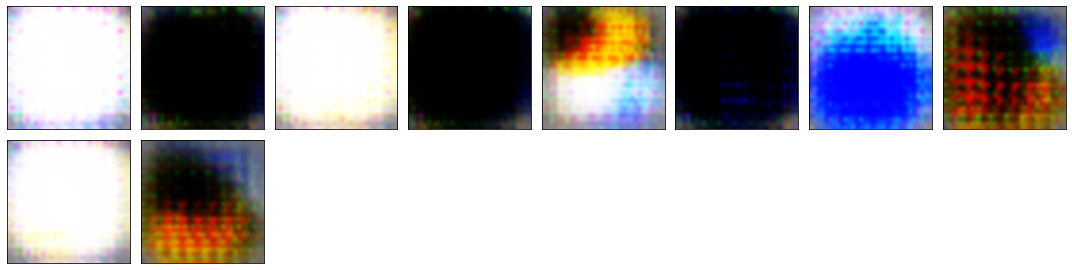

In [48]:
 import matplotlib.pyplot as plt
import numpy as np

num_generate = 10

index = 1
samples =  torch.randn(num_generate,100).cuda()

with torch.no_grad():
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(num_generate):        
        samples =  torch.randn(1, 100).cuda()
        decoded = generator(samples).cpu().numpy()
        ax = fig.add_subplot(8, 8, index)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        index = index + 1
        sq = decoded.squeeze()
        img = np.stack([sq[0, :, :], sq[1, :, :], sq[2, :, :]], axis=2)
        ax.imshow(img, interpolation='bicubic')
    
    plt.tight_layout()

**Disentangled representation**

ValueError: ignored

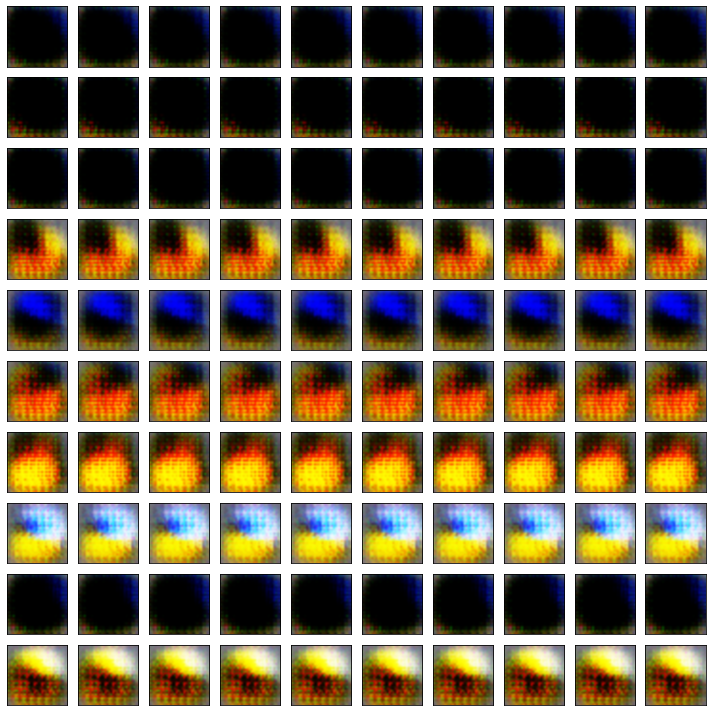

In [65]:
epsilon = 5
fig = plt.figure(figsize=(10, 10))
index = 1
for i in range(99):
    samples_ = samples.clone()
    samples_[0][i] += epsilon
    with torch.no_grad():
        for i in range(num_generate):
            decoded = generator(samples_).cpu().numpy()
            ax = fig.add_subplot(10, 10, index)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            index = index + 1
            sq = decoded.squeeze()
            img = np.stack([sq[0, :, :], sq[1, :, :], sq[2, :, :]], axis=2)
            ax.imshow(img, interpolation='bicubic')

        plt.tight_layout()

**Latent space interpolation**

In [0]:
z_0 = torch.randn(num_generate,100).cuda()
z_1 = torch.randn(num_generate,100).cuda()

alpha = [i/10 for i in range(1,11)]
fig = plt.figure(figsize=(10, 10))
index = 1


for a in alpha: 
    z_a = a*z_0 + (1-a)*z_1
    with torch.no_grad():
        for i in range(num_generate):
            decoded = generator(z_a).cpu().numpy()
            ax = fig.add_subplot(2, 5, index)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            index = index + 1
            sq = decoded.squeeze()
            img = np.stack([sq[0, :, :], sq[1, :, :], sq[2, :, :]], axis=2)
            plt.tight_layout();
            plt.imshow(img, interpolation='bicubic')

**Data space interpolation**

In [0]:
with torch.no_grad():
    x_0 = vae.decode(z_0).cpu().numpy()
    x_1 = vae.decode(z_1).cpu().numpy()

fig = plt.figure(figsize=(13, 13))
index = 1
for a in alpha:
    with torch.no_grad():
        for i in range(num_generate):
            x_a = a*x_0 + (1-a)*x_1
            ax = fig.add_subplot(2, 5, index)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            index = index + 1
            sq = x_a.squeeze()
            img = np.stack([sq[0, :, :], sq[1, :, :], sq[2, :, :]], axis=2)
            plt.tight_layout();
            plt.imshow(img, interpolation='bicubic')